In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

panel = pd.read_pickle('../Data/returns_chars_panel.pkl') 
macro = pd.read_pickle('../Data/macro_timeseries.pkl')

In [5]:
# combine micro and macro data
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro']) 

# features + targets 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs
y = df['excess_ret'] 

# Split Train Test 

In [19]:
# make 20 years of training data
date = df['date']
training = (date <= '1977-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '1977-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '1987-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

# Finding baseline model for Neural Network 

## 2 layers 

/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129 (16.13 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2094 - mse: 0.2047 - val_loss: 0.0354 - val_mse: 0.0309
Epoch 2/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0244 - mse: 0.0200 - val_loss: 0.0317 - val_mse: 0.0276
Epoch 3/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0228 - mse: 0.0187 - val_loss: 0.0308 - val_mse: 0.0270
Epoch 4/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0220 - mse: 0.0183 - val_loss: 0.0301 - val_mse: 0.0268
Epoch 5/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0212 - mse: 0.0180 - val_loss: 0.0294 - val_mse: 0.0268
Epoch 6/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0204 - mse: 0.0179 - val_loss: 0.0287 - val_mse: 0.0268
Epoch 7/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0197 - mse: 0.0178 - val_loss: 0.0285 - val_mse: 0.0270
Epoch 8/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0191 - mse: 0.0178 - val_loss: 0.0283 - val_mse: 0.0272
Epoch 9/100
1188/1188 ━━━━━━━━━━

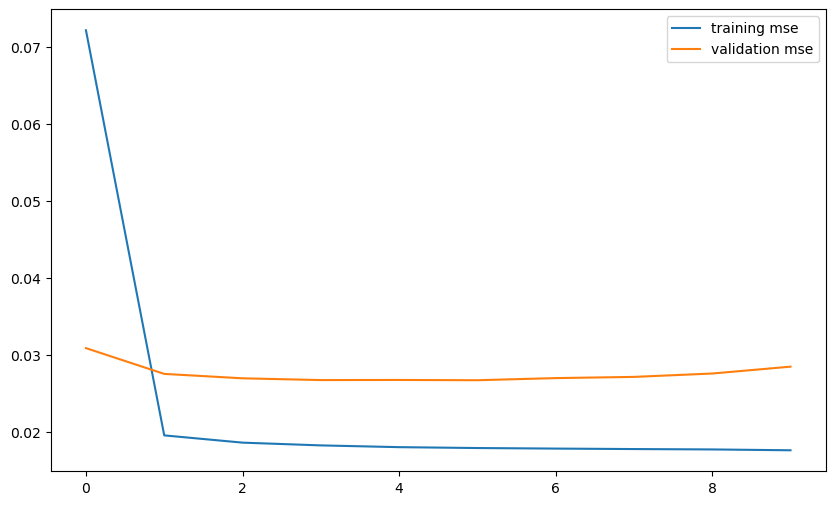

In [25]:
import tensorflow as tf
tf.random.set_seed(999)
from tensorflow.keras.models import Sequential
# Dense is the fully connected layer 
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping

# hypers
batch_size = 512
learning_rate = 1e-4
lamda = 1e-5
patience = 2

# model architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], 
                activation='relu',
                kernel_regularizer = L1(lamda), 
                # initilizing the weight and bias with normal distribution with special condition 
                kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dense(16, input_dim=X_train.shape[1], 
                activation='relu',
                kernel_regularizer = L1(lamda), 
                # initilizing the weight and bias with normal distribution with special condition 
                kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
# Output layer 
model.add(Dense(1, activation='linear',
                kernel_regularizer = L1(lamda), 
                kernel_initializer = 'he_normal'))
model.compile(loss='mse', 
              optimizer='Adam',
              metrics = ['mse'])

model.summary()
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=True,
                    validation_data = (X_val, y_val),
                    # Defined the callback to see if the validation result actually improves 
                    callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])

fig, ax = plt.subplots(figsize=(10,6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()